# Starbucks Capstone Project

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Data Analysis

In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [5]:
# Replaced None values by N
genders_dist = profile.gender.fillna('N').value_counts(normalize=True)

In [6]:
genders_dist

M    0.499059
F    0.360529
N    0.127941
O    0.012471
Name: gender, dtype: float64

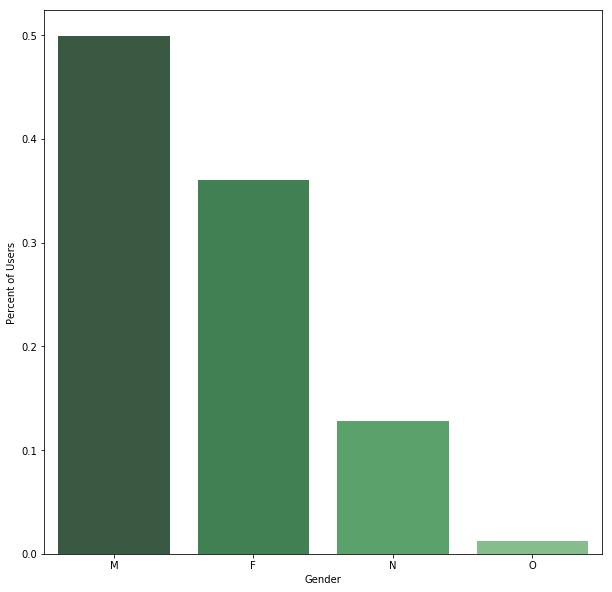

In [7]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.barplot(x=genders_dist.index, y=genders_dist.values, palette="Greens_d")

ax.set_xlabel('Gender')
ax.set_ylabel('Percent of Users')

plt.show()

In [8]:
profile.age[profile['income'].isna()].head()

0    118
2    118
4    118
6    118
7    118
Name: age, dtype: int64

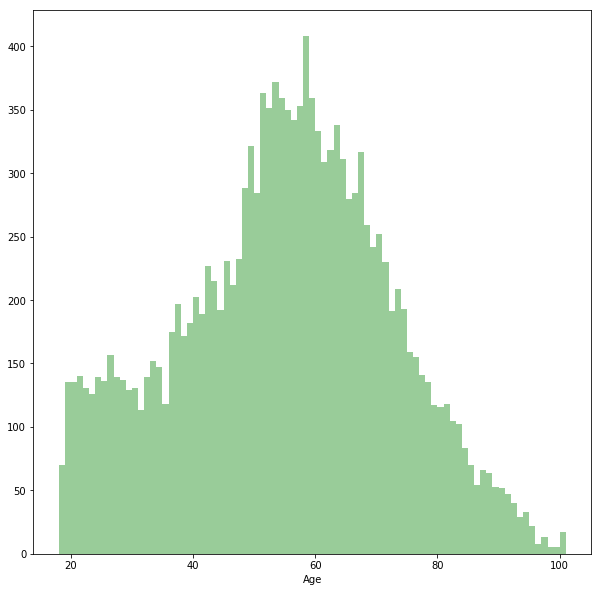

In [9]:
# Don't use value equal to 118 because of NaN values replaced by 118
fig, ax = plt.subplots(figsize = (10, 10))
sns.distplot(profile.age[profile['age'] != 118], bins=83, kde=False, color='g')

ax.set_xlabel('Age')

plt.show()

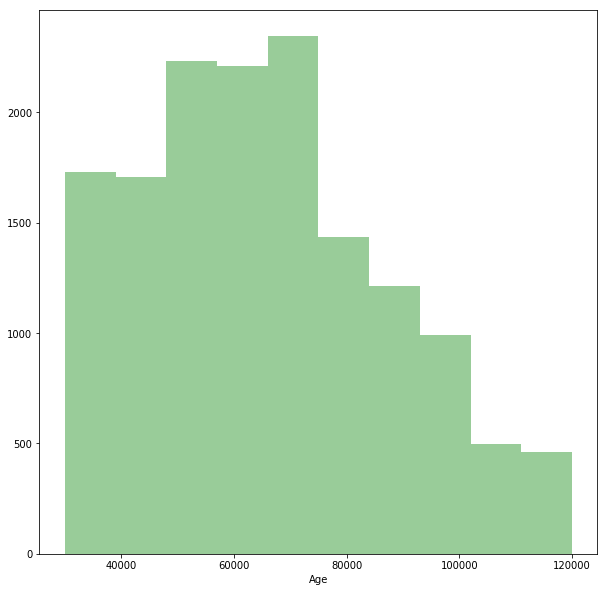

In [10]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.distplot(profile.income[~profile['income'].isna()], bins=10, kde=False, color='g')

ax.set_xlabel('Age')

plt.show()

In [11]:
profile.income.mean()

65404.9915682968

## Data Preprocessing

### Portfolio

In [12]:
portfolio_clean = portfolio.copy()

In [13]:
portfolio_clean

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [14]:
# encoding for channels
portfolio_clean['web'] = portfolio_clean['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio_clean['email'] = portfolio_clean['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio_clean['mobile'] = portfolio_clean['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio_clean['social'] = portfolio_clean['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [15]:
# create dummies for offer_type
offer_types = pd.get_dummies(portfolio_clean['offer_type'])

In [16]:
portfolio_clean = pd.concat([portfolio_clean, offer_types], axis=1, sort=False)

In [17]:
# dropped channels - encoded; dropped offer_type - dummies; dropped informational - we need k-1 columns for dummies
portfolio_clean.drop(['channels', 'offer_type', 'informational'], axis=1, inplace=True)

In [18]:
portfolio_clean

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1


### Profile

In [19]:
profile_clean = profile.copy()

In [20]:
profile_clean.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [21]:
profile_clean.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [22]:
profile_clean.gender = profile_clean.gender.fillna('N')

In [23]:
profile_clean.age = profile_clean.age.apply(lambda x: np.nan if x == 118 else x)

In [24]:
genders = pd.get_dummies(profile_clean['gender'])

In [25]:
profile_clean = pd.concat([profile_clean, genders], axis=1, sort=False)

In [26]:
profile_clean.drop(['gender', 'O'], axis=1, inplace=True)

In [27]:
profile_clean = profile_clean.fillna({'age': profile_clean.age.dropna().median()})

In [28]:
profile_clean = profile_clean.fillna({'income': profile_clean.income.dropna().median()})

In [29]:
# profile_clean.became_member_on = pd.to_datetime(profile_clean.became_member_on, format='%Y%m%d')

In [30]:
profile_clean.head()

,age,became_member_on,id,income,F,M,N
0,55.0,20170212,68be06ca386d4c31939f3a4f0e3dd783,64000.0,0,0,1
1,55.0,20170715,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0
2,55.0,20180712,38fe809add3b4fcf9315a9694bb96ff5,64000.0,0,0,1
3,75.0,20170509,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0
4,55.0,20170804,a03223e636434f42ac4c3df47e8bac43,64000.0,0,0,1


### Transcript

In [31]:
transcript_clean = transcript.copy()

In [32]:
transcript_clean.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [33]:
transcript_clean['offer_id'] = transcript_clean['value'].apply(lambda x: x.get('offer_id') or x.get('offer id'))

In [34]:
transcript_clean['amount'] = transcript_clean['value'].apply(lambda x: x.get('amount'))

In [35]:
transcript_clean = transcript_clean.drop(['value'], axis=1)

In [36]:
transcript_test = transcript_clean.sort_index().merge(portfolio[["id", "offer_type", "difficulty", "duration"]], left_on="offer_id", right_on="id", how="left")

In [37]:
transcript_test

,event,person,time,offer_id,amount,id,offer_type,difficulty,duration
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,10.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,discount,10.0,7.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,5.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5.0,5.0
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7.0,7.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,3f207df678b143eea3cee63160fa8bed,informational,0.0,4.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,10.0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,10.0


In [38]:
test = transcript_clean.sort_values(by=['person', 'time']).head(20)

In [39]:
def transcript_person_by_offers(df):
    actions = df.sort_values(by='time')
    actions.offer_id = actions.offer_id.fillna(method='ffill')
    actions = pd.pivot_table(actions, 
                             values=['time', 'amount'], 
                             index=['person', 'offer_id'], 
                             columns='event', 
                             aggfunc={'time': min, 'amount': 'first'}).reset_index()
    
    person = actions['person']
    offer_id = actions['offer_id']
    
    try:
        amount = actions['amount']['transaction']
    except KeyError:
        amount = np.nan
    
    try:
        received = actions['time']['offer received']
    except KeyError:
        received = np.nan
    
    try:
        viewed = actions['time']['offer viewed']
    except KeyError:
        viewed = np.nan
    
    try:
        completed = actions['time']['offer completed']
    except KeyError:
        completed = np.nan
    
    try:
        transaction = actions['time']['transaction']
    except KeyError:
        transaction = np.nan
     
    
    frame = {
        'person': person,
        'offer_id': offer_id,
        'received': received,
        'viewed': viewed,
        'completed': completed,
        'transaction': transaction,
        'amount': amount,
    }
    
    result = pd.DataFrame(frame) 

    return result

In [40]:
columns = ['person', 'offer_id', 'received', 'viewed', 'completed', 'transaction', 'amount']
transcript_pivoted = pd.DataFrame(columns=columns)

In [41]:
tr_users = set(transcript_clean.person)

In [42]:
for user in tr_users:
    transcript_pivoted = transcript_pivoted.append(transcript_person_by_offers(transcript_clean[transcript_clean.person == user]))

In [43]:
complete_check = transcript_pivoted.merge(portfolio[['id', 'offer_type', 'difficulty', 'duration']],
                                          left_on='offer_id', right_on='id', how='left').drop('id', axis=1)

In [44]:
complete_check.head()

,person,offer_id,received,viewed,completed,transaction,amount,offer_type,difficulty,duration
0,1a3e35ba8cd34e9286af057604fd410a,2298d6c36e964ae4a3e7e9706d1fb8c2,504,522,504,504,41.75,discount,7,7
1,1a3e35ba8cd34e9286af057604fd410a,f19421c1d4aa40978ebb69ca19b0e20d,0,84,120,120,26.19,bogo,5,5
2,3c6a74ea7f044bfb99291be2a38e4607,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,60,NaN,NaN,NaN,discount,20,10
3,3c6a74ea7f044bfb99291be2a38e4607,2298d6c36e964ae4a3e7e9706d1fb8c2,336,348,NaN,NaN,NaN,discount,7,7
4,3c6a74ea7f044bfb99291be2a38e4607,2906b810c7d4411798c6938adc9daaa5,504,504,NaN,NaN,NaN,discount,10,7


In [45]:
complete_check['end_time'] = complete_check['received'] + complete_check['duration'] * 24
complete_check['amount'] = complete_check['amount'].fillna(0)
complete_check['in_time'] = complete_check.transaction <= complete_check.end_time
complete_check['is_enough'] = complete_check.difficulty <= complete_check.amount

In [46]:
def is_success(df):
    if np.isnan(df.viewed):
        return 0
    elif np.isnan(df.transaction):
        return 0
    elif df.in_time == False:
        return 0
    elif df.is_enough == False:
        return 0
    elif df.transaction < df.viewed:
        return 0
    else:
        return 1

In [47]:
complete_check['is_success'] = complete_check.apply(is_success, axis=1)

In [48]:
data = complete_check[['is_success', 'person', 'offer_id']].\
merge(portfolio_clean, left_on='offer_id', right_on='id', how='left').drop(['id', 'offer_id'], axis=1).\
merge(profile_clean, left_on='person', right_on='id', how='left').drop(['id', 'person'], axis=1)

In [49]:
data.head()

,is_success,difficulty,duration,reward,web,email,mobile,social,bogo,discount,age,became_member_on,income,F,M,N
0,0,7,7,3,1,1,1,1,0,1,54.0,20160310,109000.0,0,1,0
1,1,5,5,5,1,1,1,1,1,0,54.0,20160310,109000.0,0,1,0
2,0,20,10,5,1,1,0,0,0,1,71.0,20180211,63000.0,1,0,0
3,0,7,7,3,1,1,1,1,0,1,71.0,20180211,63000.0,1,0,0
4,0,10,7,2,1,1,1,0,0,1,71.0,20180211,63000.0,1,0,0


In [50]:
from sklearn.utils import shuffle

In [51]:
dataset = shuffle(data).reset_index(drop=True)

In [52]:
dataset

,is_success,difficulty,duration,reward,web,email,mobile,social,bogo,discount,age,became_member_on,income,F,M,N
0,0,10,7,2,1,1,1,0,0,1,50.0,20180707,87000.0,1,0,0
1,0,10,7,10,0,1,1,1,1,0,24.0,20180425,72000.0,0,1,0
2,0,7,7,3,1,1,1,1,0,1,47.0,20171013,59000.0,0,1,0
3,0,7,7,3,1,1,1,1,0,1,58.0,20161122,72000.0,1,0,0
4,1,5,7,5,1,1,1,0,1,0,83.0,20160713,93000.0,1,0,0
5,0,10,10,2,1,1,1,1,0,1,73.0,20171130,106000.0,0,1,0
6,1,20,10,5,1,1,0,0,0,1,82.0,20161230,97000.0,0,1,0
7,1,10,5,10,1,1,1,1,1,0,51.0,20151216,81000.0,0,1,0
8,0,5,5,5,1,1,1,1,1,0,55.0,20170814,64000.0,0,0,1
9,0,0,3,0,0,1,1,1,0,0,55.0,20151013,63000.0,0,0,0


In [53]:
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

#### Random Forest Classifier

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 69)

In [56]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 69)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=69)

In [57]:
y_pred = classifier.predict(X_test)

In [58]:
cm = confusion_matrix(y_test, y_pred)

In [59]:
cm

array([[9876, 1506],
       [2606, 1834]], dtype=int64)

In [60]:
cm.sum()

15822

In [63]:
(9876 + 1834) / 15822

0.7401087093919858

In [62]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'